In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pickle
import pprint
import glob

import trimesh
import torch
import pandas as pd
from tqdm.autonotebook import tqdm
from PIL import Image
import numpy as np

from utils import utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1
from utils.visualization_tools import show_refinement_results
from utils.brute_force_pose_est import brute_force_estimate_pose

In [4]:
gridsearch_exp_name = "instance1"

device = torch.device("cuda:0")
gridsearch_folder = "out/gridsearch/{}".format(gridsearch_exp_name)
gridsearch_results_df = pd.read_pickle(os.path.join(gridsearch_folder, "eval_df.pkl"))
instance = glob.glob(os.path.join(gridsearch_folder, "*.obj"))[0].split('/')[-1].replace(".obj","")

In [5]:
display(gridsearch_results_df)

,chamfer,chamfer_norm,delta_chamfer,delta_chamfer_norm,delta_iou_3d,delta_iou_3d_norm,iou_3d,iou_3d_norm,refinement learning_rate,refinement num_iterations,refinement_number,semantic_dis_training dis_weight_path,semantic_dis_training gen_weight_path,training img_sym_lam,training l2_lam,training semantic_dis_lam,training sil_lam
0,0.005458,0.037595,0.001109,0.011972,0.002350,-0.024232,0.177154,0.174678,0.0001,350,607,out/2020_09_21--07_10_21_job5/semantic_dis_net...,out/2020_09_21--07_10_21_job5/deform_net_weigh...,0,100,2,1
1,0.009033,0.038544,0.004685,0.012922,-0.068030,-0.059852,0.106774,0.139058,0.00085,350,489,out/2020_09_21--07_10_21_job5/semantic_dis_net...,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,1000,100,50
2,0.005428,0.025012,0.001079,-0.000610,-0.017495,0.022757,0.157309,0.221667,0.00085,350,63,out/2020_09_21--07_10_21_job5/semantic_dis_net...,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,1,0,5
3,0.013041,0.057087,0.008692,0.031464,-0.104045,-0.077567,0.070759,0.121343,0.00085,350,464,out/2020_09_21--07_10_21_job5/semantic_dis_net...,,75,10,100,5
4,0.013251,0.054730,0.008902,0.029107,-0.121570,-0.040040,0.053234,0.158870,0.0001,350,920,out/2020_09_21--07_10_21_job5/semantic_dis_net...,,0,0,100,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.015830,0.075886,0.011481,0.050263,-0.160604,-0.092550,0.014200,0.106360,0.00085,350,142,out/2020_09_21--07_10_21_job5/semantic_dis_net...,,0,1,2,100
1496,0.004775,0.033277,0.000426,0.007654,0.009724,0.006974,0.184528,0.205884,4e-05,350,1117,out/2020_09_21--07_10_21_job5/semantic_dis_net...,out/2020_09_21--07_10_21_job5/deform_net_weigh...,0,100,2,5
1497,0.006625,0.036830,0.002277,0.011208,0.025450,0.043284,0.200254,0.242194,0.0001,350,583,out/2020_09_21--07_10_21_job5/semantic_dis_net...,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,1,0,50
1498,0.014279,0.080245,0.009930,0.054623,0.001739,-0.003495,0.176543,0.195415,4e-05,350,1025,out/2020_09_21--07_10_21_job5/semantic_dis_net...,out/2020_09_21--07_10_21_job5/deform_net_weigh...,0,10,0,10


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f28afc65630>]],
      dtype=object)

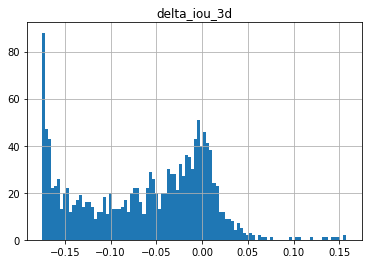

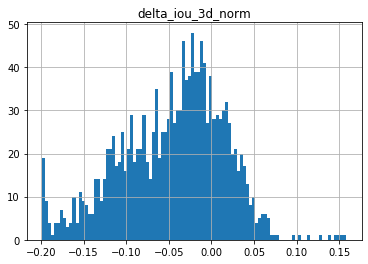

In [9]:
filtered_df = gridsearch_results_df[["iou_3d", "refinement_number", "delta_chamfer", "delta_iou_3d", "iou_3d_norm", "delta_iou_3d_norm"]]
filtered_df = filtered_df[filtered_df["delta_iou_3d"]!=-1]
filtered_df.hist(column="delta_iou_3d", bins=100)
#filtered_df.hist(column="iou_3d", bins=100)
filtered_df.hist(column="delta_iou_3d_norm", bins=100)
#filtered_df.hist(column="iou_3d_norm", bins=100)

In [21]:
# displaying dataframe info for top 15 iou_3d refinements in gridsearch
cols_to_not_show = ["delta_chamfer", "delta_iou_3d", "semantic_dis_training dis_weight_path", "refinement num_iterations" ]
best_refinements_iou3d_df = gridsearch_results_df.sort_values("iou_3d", ascending=False)[:15].drop(cols_to_not_show, axis=1)
best_refinements_iou3d_nums = list(best_refinements_iou3d_df["refinement_number"])
display(best_refinements_iou3d_df)

,chamfer,chamfer_norm,delta_chamfer_norm,delta_iou_3d_norm,iou_3d,iou_3d_norm,refinement learning_rate,refinement_number,semantic_dis_training gen_weight_path,training img_sym_lam,training l2_lam,training semantic_dis_lam,training sil_lam
1245,0.009036,0.033326,0.007704,0.140099,0.332509,0.339009,4e-05,1155,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,10,2,1
1499,0.010070,0.039191,0.013568,0.094909,0.330435,0.293819,4e-05,1055,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,10,0,1
119,0.012398,0.040709,0.015086,0.074038,0.324783,0.272948,4e-05,1053,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,1,0,1
852,0.007526,0.045520,0.019897,0.060420,0.321045,0.259331,0.0001,511,out/2020_09_21--07_10_21_job5/deform_net_weigh...,0,0,0,5
933,0.006880,0.045627,0.020005,0.153838,0.317343,0.352748,4e-05,1177,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,100,2,10
542,0.011273,0.032692,0.007070,0.145532,0.310714,0.344442,4e-05,1153,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,1,2,1
1434,0.013469,0.041750,0.016128,0.060113,0.305953,0.259023,4e-05,1051,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,0,0,1
280,0.007497,0.043963,0.018341,0.044262,0.293772,0.243172,0.0001,513,out/2020_09_21--07_10_21_job5/deform_net_weigh...,0,1,0,5
1302,0.007292,0.043977,0.018355,0.158499,0.282462,0.357409,4e-05,1077,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,100,0,10
803,0.011408,0.030564,0.004941,0.149159,0.276114,0.348069,4e-05,1151,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,0,2,1


In [20]:
# displaying dataframe info for top 15 iou_3d norm refinements in gridsearch
cols_to_not_show = ["delta_chamfer", "delta_iou_3d", "semantic_dis_training dis_weight_path", "refinement num_iterations" ]
best_refinements_iou3d_norm_df = gridsearch_results_df.sort_values("iou_3d_norm", ascending=False)[:15].drop(cols_to_not_show, axis=1)
best_refinements_iou3d_norm_nums = list(best_refinements_iou3d_norm_df["refinement_number"])
display(best_refinements_iou3d_norm_df)

,chamfer,chamfer_norm,delta_chamfer_norm,delta_iou_3d_norm,iou_3d,iou_3d_norm,refinement learning_rate,refinement_number,semantic_dis_training gen_weight_path,training img_sym_lam,training l2_lam,training semantic_dis_lam,training sil_lam
1302,0.007292,0.043977,0.018355,0.158499,0.282462,0.357409,4e-05,1077,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,100,0,10
933,0.006880,0.045627,0.020005,0.153838,0.317343,0.352748,4e-05,1177,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,100,2,10
803,0.011408,0.030564,0.004941,0.149159,0.276114,0.348069,4e-05,1151,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,0,2,1
542,0.011273,0.032692,0.007070,0.145532,0.310714,0.344442,4e-05,1153,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,1,2,1
1245,0.009036,0.033326,0.007704,0.140099,0.332509,0.339009,4e-05,1155,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,10,2,1
1313,0.009340,0.024622,-0.001001,0.128409,0.193441,0.327319,4e-05,1251,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,0,10,1
1030,0.007878,0.027940,0.002317,0.112384,0.222387,0.311294,4e-05,1253,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,1,10,1
748,0.007526,0.030424,0.004801,0.104495,0.221653,0.303406,4e-05,1497,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,100,100,100
1499,0.010070,0.039191,0.013568,0.094909,0.330435,0.293819,4e-05,1055,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,10,0,1
1464,0.005799,0.023466,-0.002157,0.077922,0.153841,0.276832,0.0001,553,out/2020_09_21--07_10_21_job5/deform_net_weigh...,75,1,0,1


In [13]:
input_image = Image.open(os.path.join(gridsearch_folder, "{}.png".format(instance)))
mesh_original_path = os.path.join(gridsearch_folder, "{}.obj".format(instance))
with torch.no_grad():
    mesh_original = utils.load_untextured_mesh(mesh_original_path, device)
mask = np.asarray(input_image)[:,:,3] > 0
pred_azim, pred_elev, pred_dist, _, _ = brute_force_estimate_pose(mesh_original, mask, 20, 20, 40, device, 8)

out/gridsearch/instance1/0085_gridsearch/1155.obj


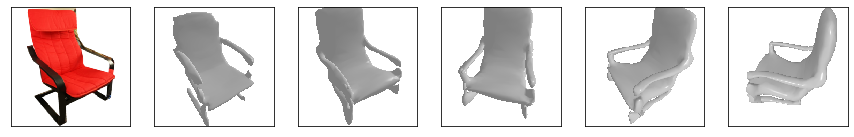

out/gridsearch/instance1/0085_gridsearch/1055.obj


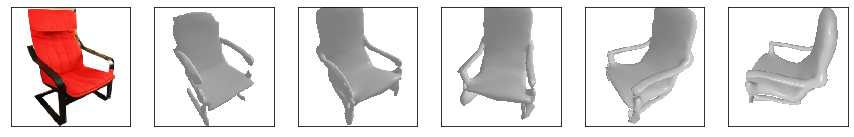

out/gridsearch/instance1/0085_gridsearch/1053.obj


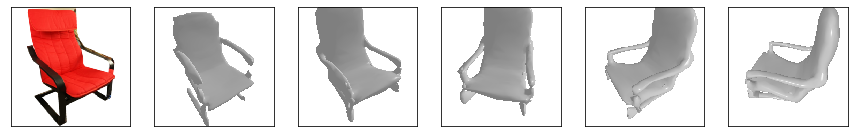

out/gridsearch/instance1/0085_gridsearch/511.obj


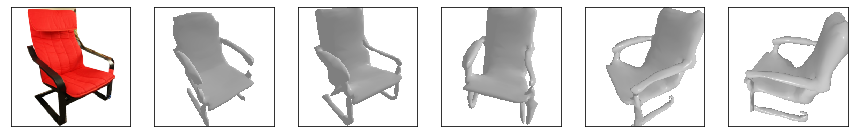

out/gridsearch/instance1/0085_gridsearch/1177.obj


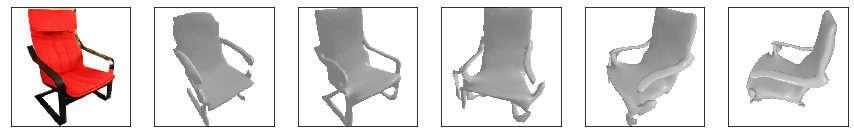

In [23]:
# visualizing top iou3d refinements in gridsearch
for refinement_num in best_refinements_iou3d_nums[:5]:
    mesh_processed_path = os.path.join(gridsearch_folder, "{}_gridsearch".format(instance), "{}.obj".format(refinement_num))
    print(mesh_processed_path)
    with torch.no_grad():
        mesh_processed = utils.load_untextured_mesh(mesh_processed_path, device)
    show_refinement_results(input_image, mesh_original, mesh_processed, pred_dist, pred_elev, pred_azim, device, num_novel_view=3)

out/gridsearch/instance1/0085_gridsearch/1077.obj


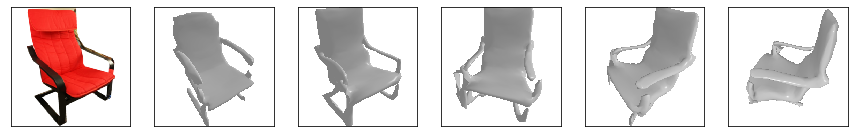

out/gridsearch/instance1/0085_gridsearch/1177.obj


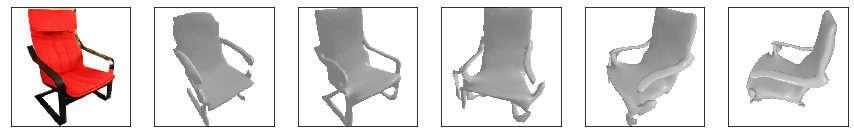

out/gridsearch/instance1/0085_gridsearch/1151.obj


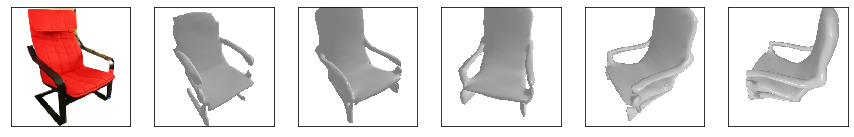

out/gridsearch/instance1/0085_gridsearch/1153.obj


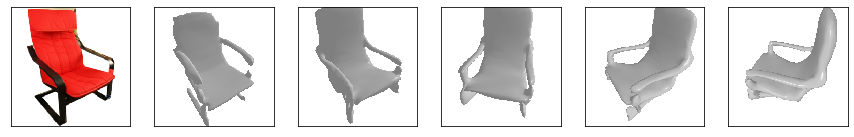

out/gridsearch/instance1/0085_gridsearch/1155.obj


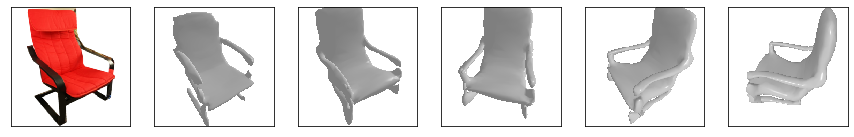

In [24]:
# visualizing top iou3d_norm refinements in gridsearch
for refinement_num in best_refinements_iou3d_norm_nums[:5]:
    mesh_processed_path = os.path.join(gridsearch_folder, "{}_gridsearch".format(instance), "{}.obj".format(refinement_num))
    print(mesh_processed_path)
    with torch.no_grad():
        mesh_processed = utils.load_untextured_mesh(mesh_processed_path, device)
    show_refinement_results(input_image, mesh_original, mesh_processed, pred_dist, pred_elev, pred_azim, device, num_novel_view=3)

# Multi Analysis

,delta_iou_3d,delta_iou_3d_norm
843,0.069053,0.055628
1009,0.065181,0.041400
793,0.062823,0.050802
1027,0.062767,0.055859
384,0.056097,0.051772
467,0.055749,0.064015
551,0.053776,0.049296
526,0.053664,0.062596
604,0.053623,0.027156
1062,0.053504,0.030657


,delta_iou_3d,delta_iou_3d_norm
80,0.020208,0.064056
467,0.055749,0.064015
526,0.053664,0.062596
89,0.042267,0.062178
1027,0.062767,0.055859
843,0.069053,0.055628
193,0.042868,0.055448
142,0.035232,0.054453
1450,0.041961,0.052594
384,0.056097,0.051772


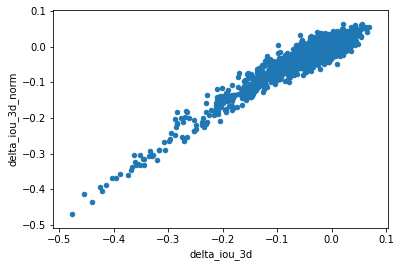

In [31]:
avg_df = None
for i in range(1,11):
    gridsearch_exp_name = "instance{}".format(i)
    gridsearch_folder = "out/gridsearch/{}".format(gridsearch_exp_name)
    gridsearch_results_df = pd.read_pickle(os.path.join(gridsearch_folder, "eval_df.pkl"))
    instance = glob.glob(os.path.join(gridsearch_folder, "*.obj"))[0].split('/')[-1].replace(".obj","")
    if avg_df is None:
        avg_df = gridsearch_results_df[["delta_iou_3d", "delta_iou_3d_norm"]]
    else:
        avg_df += gridsearch_results_df[["delta_iou_3d", "delta_iou_3d_norm"]]

display((avg_df/10).sort_values("delta_iou_3d", ascending=False)[:20])
display((avg_df/10).sort_values("delta_iou_3d_norm", ascending=False)[:20])
display((avg_df/10).plot.scatter("delta_iou_3d", "delta_iou_3d_norm"))

In [ ]:
['refinement learning_rate', 'refinement num_iterations', 'training semantic_dis_lam', 'training img_sym_lam', 'training sil_lam', 'training l2_lam', 'semantic_dis_training gen_weight_path', 'semantic_dis_training dis_weight_path']

843 -- (0.0001, 350, 30, 0, 100, 1, 'out/2020_09_21--07_10_21_job5/deform_net_weights_99.pt', 'out/2020_09_21--07_10_21_job5/semantic_dis_net_weights_99.pt')

#1009 -- (4e-05, 350, 0, 0, 1, 1000, 'out/2020_09_21--07_10_21_job5/deform_net_weights_99.pt', 'out/2020_09_21--07_10_21_job5/semantic_dis_net_weights_99.pt')

1027 -- (4e-05, 350, 0, 0, 10, 100, 'out/2020_09_21--07_10_21_job5/deform_net_weights_99.pt', 'out/2020_09_21--07_10_21_job5/semantic_dis_net_weights_99.pt')

#793 -- (0.0001, 350, 10, 75, 100, 1, 'out/2020_09_21--07_10_21_job5/deform_net_weights_99.pt', 'out/2020_09_21--07_10_21_job5/semantic_dis_net_weights_99.pt')

#467 -- (0.00085, 350, 100, 75, 5, 100, 'out/2020_09_21--07_10_21_job5/deform_net_weights_99.pt', 'out/2020_09_21--07_10_21_job5/semantic_dis_net_weights_99.pt')